In [1]:
import sys, os
import pickle
import GOES
import numpy as np
import scipy as sc
import xarray as xr
import pandas as pd
from datetime import datetime

sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')
import data_clean as dc
import model1_plots as mp
import Utilities as util

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat


In [2]:
loc_data = '../data/raw_data/'
loc_clean_data = '../data/clean_data/'
input_file = '../src/input_cleandata.txt'


### Optional: determine for which dates we need to do the cleaning

In [3]:
# give time frame

def datetime64_to_time_of_day(datetime64_array):
    """
    Return a new array. For every element in datetime64_array return the time of day (since midnight).
    >>> datetime64_to_time_of_day(np.array(['2012-01-02T01:01:01.001Z'],dtype='datetime64[ms]'))
    array([3661001], dtype='timedelta64[ms]')
    >>> datetime64_to_time_of_day(np.datetime64('2012-01-02T01:01:01.001Z','[ms]'))
    numpy.timedelta64(3661001,'ms')
    """
    day = datetime64_array.astype('datetime64[D]').astype(datetime64_array.dtype)
    time_of_day = datetime64_array - day
    return time_of_day

with open('../data/raw_data/dates.txt', "rb") as f:
    dates = pickle.load(f)

with open(input_file) as f:
    input = dict([line.split() for line in f])
print(input)

start_date = datetime.strptime(input['start_date'], '%d-%m-%Y')
end_date = datetime.strptime(input['end_date'], '%d-%m-%Y')
start_time = pd.to_timedelta(input['start_time'] + ':00')
end_time = pd.to_timedelta(input['end_time'] + ':00')

date = dates['cth'].date 
# check whether t  is within start and end date 
time = datetime64_to_time_of_day(date) 
idx = (start_date < date)  & (date < end_date) & (start_time < time)  & (time < end_time)

dates['cth'] = dates['cth'][idx]

# check whether cleaning has already been done
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    clean_dates = pickle.load(f)

print(clean_dates.date)
# # print(dates)
# # start_time
# idx = [idx for idx, date in dates['cth'].iterrows() if ~(date.date == clean_dates.date).any()]
# dates['cth'] = dates['cth'].loc[idx]
dates['cth']

{'loc_data': '../data/raw_data/', 'loc_clean_data': '../data/clean_data/', 'start_date': '10-12-2020', 'end_date': '11-12-2020', 'start_time': '16:00', 'end_time': '16:59'}
0     2020-12-10 00:04:57.823948032
1     2020-12-10 00:14:57.818392960
2     2020-12-10 00:24:57.820765952
3     2020-12-10 00:34:57.816974976
4     2020-12-10 00:44:57.811352064
                   ...             
140   2020-12-10 23:34:57.595847936
141   2020-12-10 23:44:57.592283008
142   2020-12-10 23:54:57.587700992
143   2020-12-11 12:04:57.675273984
144   2020-12-11 12:14:57.671597952
Name: date, Length: 145, dtype: datetime64[ns]


,file_name,date
116,../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s2...,2020-12-10 16:04:57.887737984
117,../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s2...,2020-12-10 16:14:57.888947968
118,../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s2...,2020-12-10 16:24:57.886816000
119,../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s2...,2020-12-10 16:34:57.887676032
120,../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s2...,2020-12-10 16:44:57.881392896
121,../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s2...,2020-12-10 16:54:57.656150016


### Find the corresponding Files

In [4]:
## get an image with an existing time stamp for cth
idx_cth = 116
t = dates['cth'].loc[idx_cth].date
print(t)

# cod
dt = abs(dates['cod'].date - t)
idx_cod = dt.argmin()
if dt.loc[idx_cod] > np.timedelta64(10, 'm'):
    print(f'!Error: No cod found within 10 minutes of {t}')
    # TODO: download the right file or skip

# dm
dt = abs(dates['dm'].date - t)
idx_dm = dt.nsmallest(6).index
if dt.loc[idx_dm[0]] > np.timedelta64(1, 'h'):
    print(f'!Error: No cod found within 1 hour of {t}')

    
file_cth = dates['cth'].loc[idx_cth].file_name
file_cod = dates['cod'].loc[idx_cod].file_name
files_dm = dates['dm'].loc[idx_dm].file_name.values

print(file_cth)
print(file_cod)
print(files_dm)

2020-12-10 16:04:57.887737984
../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s20203451600124_e20203451609432_c20203451611028.nc
../data/raw_data/cod/OR_ABI-L2-CODF-M6_G16_s20203451600124_e20203451609432_c20203451611091.nc
['../data/raw_data/dm/OR_ABI-L2-DMWF-M6C02_G16_s20203451600124_e20203451609432_c20203451625431.nc'
 '../data/raw_data/dm/OR_ABI-L2-DMWF-M6C07_G16_s20203451600124_e20203451609444_c20203451624250.nc'
 '../data/raw_data/dm/OR_ABI-L2-DMWF-M6C08_G16_s20203451600124_e20203451609432_c20203451624300.nc'
 '../data/raw_data/dm/OR_ABI-L2-DMWF-M6C09_G16_s20203451600124_e20203451609438_c20203451642337.nc'
 '../data/raw_data/dm/OR_ABI-L2-DMWF-M6C10_G16_s20203451600124_e20203451609444_c20203451642332.nc'
 '../data/raw_data/dm/OR_ABI-L2-DMWF-M6C14_G16_s20203451600124_e20203451609432_c20203451624486.nc']


In [5]:
file_cth

'../data/raw_data/cth/OR_ABI-L2-ACHAF-M6_G16_s20203451600124_e20203451609432_c20203451611028.nc'

In [6]:
def plotImage(image, var = 'cod', ax = None, norm = None, add_colorbar = True, cbar_label = ''):
    domain = image.extent
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize = (14, 8), sharex = True, sharey = True)
        
    ## base map with coast lines
    if os.path.exists("../lib/coast.mat"):
        coast = loadmat("../lib/coast.mat")
        ax.plot(coast["long"], coast["lat"], color='r', linewidth=1)
        
    if norm == 'log':
        norm = mpl.colors.LogNorm()
    
    fig_cod = ax.pcolormesh(image.lon.data, image.lat.data, image[var], norm = norm)
    ax.set_xlim([domain[0], domain[1]])
    ax.set_ylim([domain[2], domain[3]])
    ax.set_title(var)
    if add_colorbar:
        cbar = plt.colorbar(fig_cod, ax = ax)
        cbar.set_label(cbar_label)

    if ax is None:
        return fig, ax
    else:
        return ax


In [7]:
xr.open_dataset(file_cth)

<xarray.Dataset>
Dimensions:                                 (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 1086, y: 1086)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1519 ... -0.1519
  * x                                       (x) float32 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    local_zenith_angle                      float32 ...
    solar_zenith_angle                      float32 ...
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables: (12/23)
    HT                                      (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_product_version_container     int32 ...
    local_zenith_angle_bounds               (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    cloud_pixels                            float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2020-12-10T16:00:12.4Z
    time_coverage_end:         2020-12-10T16:09:43.2Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        6554da44-6b83-4a72-9958-0faa0394d160

### Area masking & Interpolation CTH & COD

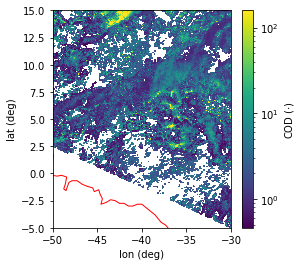

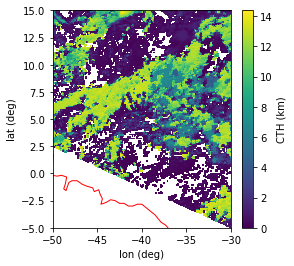

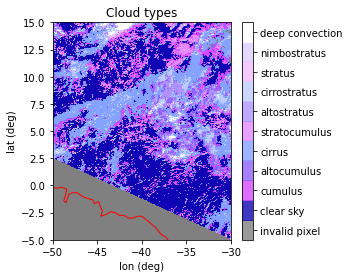

In [8]:
plt.rcParams["figure.figsize"] = (4,4)

cod_cth = dc.combineCOD_CTH(file_cod, file_cth) # gives interpolated cth and domain to right square

# Classify the clouds
ct = dc.classifyISCCP(cod_cth.cod, cod_cth.cth, cod_cth.dqf_cod)
da = cod_cth.assign(ct = (["x", "y"], ct))
da = da.where(da.lat - dc.coastLine(da.lon) > 0)

fig, ax = plt.subplots(1,1)
plotImage(da, ax = ax, var = 'cod', norm = 'log', cbar_label = 'COD ($\cdot$)')
ax.set_xlabel('lon (deg)')
ax.set_ylabel('lat (deg)')
ax.set(title = '')
fig.savefig('../fig/data/cod', dpi = 300)

fig, ax = plt.subplots(1,1)
da2 = da.copy(deep = True)
da2['cth'] = da.cth * 1e-3
plotImage(da2, ax = ax, var = 'cth', cbar_label = 'CTH (km)')
ax.set_xlabel('lon (deg)')
ax.set_ylabel('lat (deg)')
ax.set(title = '')
fig.savefig('../fig/data/cth', dpi = 300)

fig, ax = mp.plotCT(da.ct, xcoord = 'lon', ycoord = 'lat', 
                    figsize = (4,4),
                   equal_axis = False)
plotImage(da.where(0), ax = ax, var = 'cod', add_colorbar = False)


ax.set_xlim([da.extent[0], da.extent[1]])
ax.set_ylim([da.extent[2], da.extent[3]])
ax.set_xlabel('lon (deg)')
ax.set_ylabel('lat (deg)')
ax.set_title( 'Cloud types')
fig.savefig('../fig/data/cloud_types', dpi = 300, bbox_inches= 'tight', pad = .3)

plt.show()

In [9]:
da

<xarray.Dataset>
Dimensions:  (x: 535, y: 430)
Coordinates:
    lon      (x, y) float32 -50.0 -49.95 -49.91 -49.87 ... -29.91 -29.85 -29.79
    lat      (x, y) float32 15.0 15.0 15.0 15.0 ... -5.12 -5.121 -5.122 -5.122
  * x        (x) float64 0.0 0.001873 0.003745 0.005618 ... 0.9963 0.9981 1.0
  * y        (y) float64 0.0 0.002331 0.004662 0.006993 ... 0.9953 0.9977 1.0
    time     datetime64[ns] 2020-12-10T16:04:57.887737984
Data variables:
    cod      (x, y) float32 15.36 3.745 2.605 3.98 29.29 ... nan nan nan nan nan
    dqf_cod  (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan nan
    cth      (x, y) float32 2.752e+03 2.752e+03 2.915e+03 ... nan nan nan
    ct       (x, y) float64 6.0 6.0 3.0 6.0 9.0 6.0 ... nan nan nan nan nan nan
Attributes:
    extent:   [-50.0, -30.0, -5.0, 15.0]

Frozen(SortedKeysDict({'mu_h': 79, 'mu_d': 28, 'mu_hN': 13, 'mu_dN': 8, 'cs_mu_hN': 63, 'cs_mu_dN': 11, 'mu_csf': 10, 'method': 2, 'var_cth_bm': 5, 'var_cod': 2, 'var_cth_b': 2}))


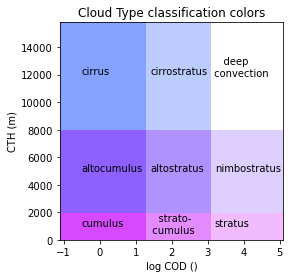

In [5]:
loc_model = '../mod/model2/'
ds = xr.open_dataset(loc_model + 'paramters_without_nan.nc').load()
print(ds.dims)
mu_d_2 = np.linspace(-1, 5, endpoint = True, num = 31)
ds = ds.assign_coords(mu_d_2=("mu_d_2", mu_d_2))
D, H = np.meshgrid(np.exp(ds.mu_d_2), ds.mu_h)
ds['ct'] = (['mu_h', 'mu_d_2'], util.classISCCP(D, H))

fig, ax = mp.plotCT(ds.ct, xcoord = 'mu_d_2', ycoord = 'mu_h', 
                    figsize = (4,4),
                   equal_axis = False,
                   alpha = 1,
                   add_colorbar = False
                   )
ax.set_xlabel('log COD ()')
ax.set_ylabel('CTH (m)')
ax.set_title( 'Cloud Type classification colors')

classes = util.ISCCP_classes.values()
d = [-100, -100, -.5,-.5,-.5, 1.3,1.4,1.4, 3.2,3.2,3.1]
h = [-100, -100, 1000, 5000, 12000 ,600, 5000, 12000 ,1000, 5000, 12000 ]
for i, txt in zip(range(len(classes)), classes):
    if i == 10:
        txt = '    deep \n convection'
    if i == 5:
        txt = '    strato-\n  cumulus'
    if i < 2:
        continue
    ax.annotate(txt, (d[i], h[i]), fontsize = 10, wrap = True)
fig.savefig('../fig/colorbar_cloudtypes', dpi = 300, bbox_inches= 'tight', pad = .2)


In [26]:
ds.mu_d

<xarray.DataArray 'mu_d' (mu_d: 28)>
array([-1.000000e+00, -8.000000e-01, -6.000000e-01, -4.000000e-01,
       -2.000000e-01, -2.220446e-16,  2.000000e-01,  4.000000e-01,
        6.000000e-01,  8.000000e-01,  1.000000e+00,  1.200000e+00,
        1.400000e+00,  1.600000e+00,  1.800000e+00,  2.000000e+00,
        2.200000e+00,  2.400000e+00,  2.600000e+00,  2.800000e+00,
        3.000000e+00,  3.200000e+00,  3.400000e+00,  3.600000e+00,
        3.800000e+00,  4.000000e+00,  4.200000e+00,  4.400000e+00])
Coordinates:
    n_or_val  <U3 'val'
  * mu_d      (mu_d) float64 -1.0 -0.8 -0.6 -0.4 -0.2 ... 3.6 3.8 4.0 4.2 4.4
    est       <U4 'coef'

### Night time masking and other data flags

In [7]:
# ds_cod_goes = GOES.open_dataset(file_cod)
# ds_cod = xr.open_dataset(file_cod)

# cod, LonCor, LatCor = ds_cod_goes.image('COD', lonlat='corner', domain=[-50.0,-30.0,-5.0,15.0])
# dqf_cod, LonCor, LatCor = ds_cod_goes.image('DQF', lonlat='corner', domain=[-50.0,-30.0,-5.0,15.0])
# ds_cod.DQF[:]

In [8]:
# plt.imshow(ds_cod.DQF)


In [18]:
ds_cod = xr.open_dataset(file_cth)
ds_cod

<xarray.Dataset>
Dimensions:                                 (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 1086, y: 1086)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1519 ... -0.1519
  * x                                       (x) float32 -0.1519 ... 0.1519
    y_image                                 float32 ...
    x_image                                 float32 ...
    local_zenith_angle                      float32 ...
    solar_zenith_angle                      float32 ...
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables: (12/23)
    HT                                      (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_product_version_container     int32 ...
    local_zenith_angle_bounds               (number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    cloud_pixels                            float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2020-12-10T16:00:12.4Z
    time_coverage_end:         2020-12-10T16:09:43.2Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        6554da44-6b83-4a72-9958-0faa0394d160

### Projection to meters
Length in meters of 1° of latitude = always 111.32 km

Length in meters of 1° of longitude = 40075 km * cos( latitude ) / 360

In [19]:
centerpoint = [5, -40] # deg lat, deg lon
scale_lat = 111.32e3 #m
scale_lon = 40075e3 * np.cos( centerpoint[0] * np.pi/ 180 ) / 360 #m

def latlon_to_meters(lat, lon, 
                     centerpoint = centerpoint
                    ):

    return (lon - centerpoint[1]) * scale_lon , (lat - centerpoint[0]) * scale_lat

def meters_to_latlon(x, y, 
                     centerpoint = centerpoint
                    ):
    return (y / scale_lat) + centerpoint[0], (x / scale_lon) + centerpoint[1]

xx, yy = latlon_to_meters(da.lat, da.lon)

# plt.pcolormesh(xx * 1e-3, yy * 1e-3, da.lon)
# plt.xlabel('E')
# plt.ylabel('N')
# plt.show()


da_m = da.assign_coords({"X" : xx, "Y": yy})

## Interpolate to equidistant grid


In [20]:
# create equidistant grid within the boundaries of available data.
x_min = xx.min(axis = 0).max().values
x_max = xx.max(axis = 0).min().values
y_min = yy.min(axis = 1).max().values
y_max = yy.max(axis = 1).min().values
x_min, x_max, y_min, y_max
dx = 5e3 # m
nx = (x_max - x_min ) / dx * 1j
ny = (y_max - y_min ) / dx * 1j
grid_x, grid_y = np.mgrid[x_min:x_max:nx, y_min:y_max:ny] # maybe find extent bit more precise

# points where we have the values of the data
points = np.empty((da_m.lat.size, 2))
points[:, 0] = da_m.X.values.flatten()
points[:, 1] = da_m.Y.values.flatten()

# select a single timestep in which to interpolate the data
cth_old = da_m.cth.values.flatten()
cod_old = da_m.cod.values.flatten()
ct_old = da_m.ct.values.flatten()

cth = sc.interpolate.griddata(points, cth_old, (grid_x, grid_y), method='nearest')
cod = sc.interpolate.griddata(points, cod_old, (grid_x, grid_y), method='nearest')
ct = sc.interpolate.griddata(points, ct_old, (grid_x, grid_y), method='nearest')


## make new xarray with new coordinates in meters
    #put cod data in xarray
d = xr.Dataset(
        data_vars=dict(
            cth=(["x", "y"], cth),
            cod=(["x", "y"], cod), 
            ct=(["x", "y"], ct), 
        ),
        coords=dict(
            x = (["x"], grid_x[:, 0]),
            y = (["y"], grid_y[0, :]),
            t=da_m.time.data,
        ),
        attrs = dict(extent = da_m.extent)
    )

d

<xarray.Dataset>
Dimensions:  (x: 441, y: 443)
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
    t        datetime64[ns] 2020-12-10T16:04:57.887737984
Data variables:
    cth      (x, y) float32 695.9 413.6 413.6 413.6 960.8 ... nan nan nan nan
    cod      (x, y) float32 1.15 1.465 2.11 2.102 3.174 ... nan nan nan nan nan
    ct       (x, y) float64 2.0 2.0 2.0 2.0 2.0 5.0 ... nan nan nan nan nan nan
Attributes:
    extent:   [-50.0, -30.0, -5.0, 15.0]

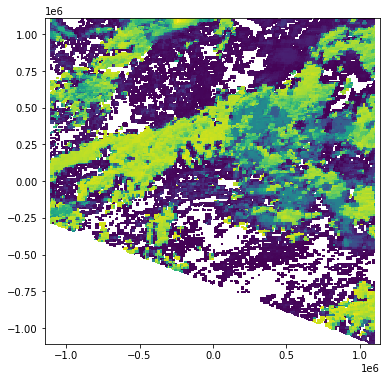

In [21]:
plt.pcolormesh(grid_x, grid_y, cth)
plt.axis('equal')
plt.show()

### Advection

In [22]:
# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in files_dm:
    ds = xr.open_dataset(file)

    nMeasures = ds.nMeasures[(ds.lon< -30) &
                             (ds.lon> -50) &
                             (ds.lat > -5.0) &
                             (ds.lat < 15.0 ) &
                             (ds.lat - dc.coastLine(ds.lon) > 0) &  # Delete over land points
                             ~(np.isnan(ds.wind_speed))             # Delete points which do not contain a wind speed

                            ]
    ds_small = ds[dict(nMeasures=nMeasures)]
    dss.append(ds_small)

ds_wind = xr.concat(dss, 'nMeasures')
ds_wind

<xarray.Dataset>
Dimensions:                                                     (atmospheric_layer: 3, dmw_band: 1, nMeasures: 7646, number_atmospheric_layer_bounds: 2, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2)
Coordinates:
    lat                                                         (nMeasures) float64 ...
    lon                                                         (nMeasures) float64 ...
    time                                                        (nMeasures) datetime64[ns] ...
    pressure                                                    (nMeasures) float32 ...
    local_zenith_angle                                          (nMeasures) float32 ...
    solar_zenith_angle                                          (nMeasures) float32 ...
    lat_image                                                   float32 0.0
    lon_image                                                   float32 -75.0
    retrieval_local_zenith_angle                                float32 90.0
    atmospheric_layer_pressure                                  (atmospheric_layer) float32 ...
    band_id                                                     (nMeasures, dmw_band) int8 ...
    band_wavelength                                             (nMeasures, dmw_band) float32 ...
Dimensions without coordinates: atmospheric_layer, dmw_band, nMeasures, number_atmospheric_layer_bounds, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables: (12/35)
    wind_speed                                                  (nMeasures) float32 ...
    wind_direction                                              (nMeasures) float32 ...
    temperature                                                 (nMeasures) float32 ...
    DQF                                                         (nMeasures) float32 ...
    lat_image_bounds                                            (nMeasures, number_of_image_bounds) float32 ...
    lon_image_bounds                                            (nMeasures, number_of_image_bounds) float32 ...
    ...                                                          ...
    percent_uncorrectable_GRB_errors                            (nMeasures) float64 ...
    percent_uncorrectable_L0_errors                             (nMeasures) float64 ...
    algorithm_dynamic_input_data_container                      (nMeasures) int32 ...
    processing_parm_version_container                           (nMeasures) int32 ...
    algorithm_product_version_container                         (nMeasures) int32 ...
    solar_zenith_angle_bounds                                   (nMeasures, number_of_SZA_bounds) float32 ...
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    standard_name:             solar_zenith_angle
    units:                     degree
    bounds:                    solar_zenith_angle_bounds
    dataset_name:              OR_ABI-L2-DMWF-M6C02_G16_s20203451600124_e2020...
    spatial_resolution:        10km at nadir
    id:                        fdd91c72-08ab-46c5-92f5-3cd17f3337cf

In [23]:
[len(ds.nMeasures) for ds in dss]

[5301, 0, 805, 104, 3, 1433]

In [24]:
# Determine coordinates in X-Y plane
xx, yy = latlon_to_meters(ds_wind.lat,ds_wind.lon)
ds_wind = ds_wind.assign_coords({"X" : xx, "Y": yy})


In [25]:
# points where we have the values of the data
points = np.empty((ds_wind.X.size, 2))
points[:, 0] = ds_wind.X
points[:, 1] = ds_wind.Y
z = ds_wind.wind_speed * np.exp(1j * ds_wind.wind_direction / 180 * np.pi)


wind = sc.interpolate.griddata(points, z, (grid_x, grid_y), method='nearest')


In [26]:
# add wind field to dataset
ws = np.abs(wind)
wd = np.angle(wind)


d = d.assign({"u" : (("x", "y"), np.real(wind)),
              "v" : (("x", "y"), np.imag(wind))}) 

d.u.attrs["units"] = "m s-1"
d.v.attrs["units"] = "m s-1"

# delete values above land
lat, lon = meters_to_latlon(d.x, d.y)
d = d.where(lat - dc.coastLine(lon) > 0)
d
    

<xarray.Dataset>
Dimensions:  (x: 441, y: 443)
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
    t        datetime64[ns] 2020-12-10T16:04:57.887737984
Data variables:
    cth      (x, y) float32 695.9 413.6 413.6 413.6 960.8 ... nan nan nan nan
    cod      (x, y) float32 1.15 1.465 2.11 2.102 3.174 ... nan nan nan nan nan
    ct       (x, y) float64 2.0 2.0 2.0 2.0 2.0 5.0 ... nan nan nan nan nan nan
    u        (x, y) float32 5.16 5.16 5.16 5.16 5.16 ... nan nan nan nan nan
    v        (x, y) float32 8.962 8.962 8.962 8.962 8.962 ... nan nan nan nan
Attributes:
    extent:   [-50.0, -30.0, -5.0, 15.0]

AttributeError: 'Dataset' object has no attribute 'lon'

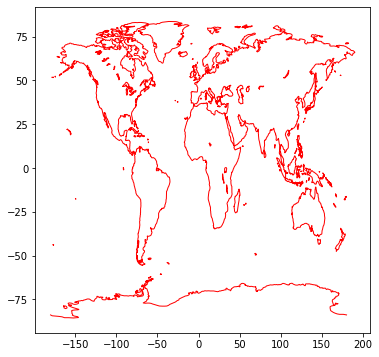

In [27]:

fig, ax = plt.subplots(1,1)
plotImage(d, ax = ax, var = 'u')
ax.set_xlabel('lon (deg)')
ax.set_ylabel('lat (deg)')
fig.savefig('../fig/data/cth')



In [12]:
# plt.pcolormesh(grid_x, grid_y, np.angle(d.wind), shading='auto', cmap = 'twilight')
# plt.colorbar()
# plt.axis("equal")
# plt.show()
# plt.pcolormesh(grid_x, grid_y, np.abs(d.wind), shading='auto')
# plt.colorbar()
# plt.axis("equal")
# plt.show()
# plt.pcolormesh(grid_x, grid_y, d.ct, shading='auto')
# plt.colorbar()
# plt.axis("equal")
# plt.show()

### Save dataSet at the right location

In [13]:
def saveDs(ds, output_loc):
    date = ds.t.data
    ts = pd.to_datetime(str(date)) 
    d = ts.strftime('%Y%m%d-%Hh%M%S') # maybe change day/month to julian days
    file_name = f'{output_loc}/image_{d}.nc'
    ds.to_netcdf(file_name)
    return file_name

file_name = saveDs(d, loc_clean_data)

### Make file with cleaned dates

In [3]:
## create dictionairy with all available dates
path = loc_clean_data
files = [path + f for f in os.listdir(path) if (os.path.isfile(os.path.join(path, f)) and 'image' in f)]
acq_dates = dc.acquisitionDates(files)
dates = pd.DataFrame({'file_name': files, 'date': acq_dates } )

with open(loc_clean_data + 'clean_dates.txt', 'wb') as outfile:
    pickle.dump(dates, outfile)

In [4]:
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    x = pickle.load(f)

print(x)

Empty DataFrame
Columns: [file_name, date]
Index: []
